### Dependencies

In [1]:
import kagglehub
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Downloding dataset

In [2]:
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
print("Path to dataset:", path)

Path to dataset: C:\Users\abamr\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\1


### Reading 

In [3]:
true_news = pd.read_csv(path + "/True.csv")
fake_news = pd.read_csv(path + "/Fake.csv")


In [4]:
true_news['label'] = 1
fake_news['label'] = 0

# Combine both datasets
data = pd.concat([true_news, fake_news], ignore_index=True)
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Tokenizing,lemmetizing and removing stopwords

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars & numbers
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords + lemmatize
    return ' '.join(tokens)
data['text'] = (data['title'] + " " + data['text']).astype(str)
data.head()


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",1


### splitting

In [7]:
from sklearn.model_selection import train_test_split

y = data['label']
X_train_full, X_temp, y_train_full, y_temp = train_test_split(data['text'], y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Then: Validation + Test (split temp into two halves)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test



### Training

In [14]:
# Create pipeline
import token
from tokenize import tokenize
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import joblib

model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000,tokenizer=preprocess_text)),
    ('model', LinearSVC())  
])
model.fit(X_train_full, y_train_full)

# ✅ Predictions


# ✅ Accuracy Scores

# Save the entire pipeline
joblib.dump(model, "fake_new_classifier_linearsvc.pkl")

['fake_new_classifier_linearsvc.pkl']

In [15]:

model = joblib.load("fake_new_classifier_linearsvc.pkl")
val_pred = model.predict(X_val)

test_pred = model.predict(X_test)


In [16]:
print("Validation Set Results:")
val_acc = accuracy_score(y_val, val_pred)
print("Accuracy for val:",val_acc)
print("F1-score: for val:", f1_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

print("Test Set Results:")
test_acc = accuracy_score(y_test, test_pred)
print("Accuracy for test:", test_acc)
print("F1-score: for test:", f1_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Validation Set Results:
Accuracy for val: 0.7826280623608017
F1-score: for val: 0.7714285714285715
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4698
           1       0.77      0.77      0.77      4282

    accuracy                           0.78      8980
   macro avg       0.78      0.78      0.78      8980
weighted avg       0.78      0.78      0.78      8980

Test Set Results:
Accuracy for test: 0.7831848552338531
F1-score: for test: 0.7739463601532567
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4661
           1       0.78      0.77      0.77      4319

    accuracy                           0.78      8980
   macro avg       0.78      0.78      0.78      8980
weighted avg       0.78      0.78      0.78      8980



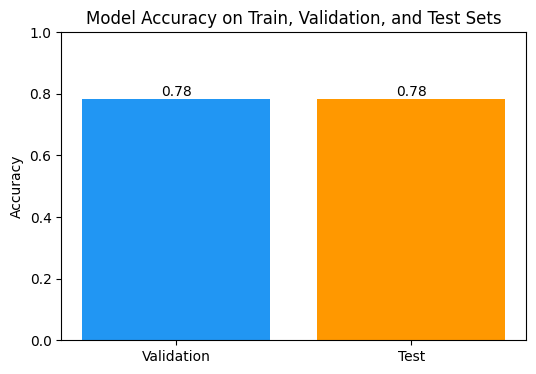

In [17]:
import matplotlib.pyplot as plt
# ✅ Plot Train, Validation, and Test Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Validation', 'Test'], [val_acc, test_acc], color=[ '#2196f3', '#ff9800'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train, Validation, and Test Sets')
for i, acc in enumerate([val_acc, test_acc]):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)
plt.show()


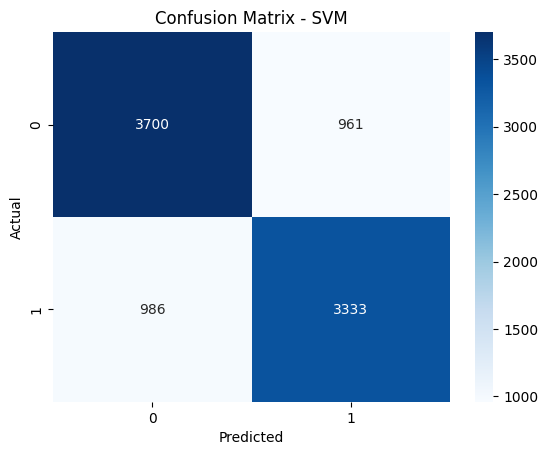

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()